##Summary
After introducing gradient clipping to solve the nan training problem we now have a new hyperparameter: How much should the gradients be clipped at (before the learning rate is applied). 
Prelim analysis showed that the average gradients were very small, with many outliers (probably the gradients that are actually important). The SD of the gradients was highest at the first epoch and the values ranged between -1 to 1. This ranged dropped to approx -0.02 to 0.02 in later epochs. 
The different hyperparameter combinations tested:
Learning rate : 0.2 - a learning rate that isn't possible without clipping because it lead to NaN models. 0.002 - a standard learning rate
Clip: 5 - only for real instances of exploding gradients. 1 - will clip some values in first few epochs. 0.5 - Will clip many values in first few epochs. 0.1 - will clip some values even in later epochs. 0.025 - will continuously clip values.
Seed: Two runs at each combination were run

##Results

A clip of 1-2 should be the best

In [1]:
# So that packages are automatically reloaded if analysis functions need to be updated
%load_ext autoreload
%autoreload 2
# We need to include the module in the path
import pathlib
import sys
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
# Set up path stuff (to orient the notebook within the package structure)
module_path = pathlib.Path.cwd()
base_dir = module_path.parent.absolute()
model_dir = base_dir / "models" / "trained"
sys.path.append(str(base_dir))
# Now we can import package modules
from src.analysis.analysis_functions import *

In [2]:
print("Loading run data...")
df = get_dataframe(model_dir, taskname="seedlings_clipping_3")
df = get_runs_data(df)
# Now remove the duplicate columns from - and _ metric naming
df = repair_mixed_metrics(df)

Loading run data...
Reading run info from server
Run 0 of 20 (0.00%)
Run 10 of 20 (50.00%)
Finished reading run info from server


metric params               test_MAP_step                                \
point    clip learning_rate             0         1         2         3   
0       5.000         0.002      0.266217  0.396245  0.427049  0.434910   
1       0.100         0.200      0.316051  0.363207  0.333935  0.489835   
2       0.100         0.200      0.203709  0.368297  0.368948  0.432231   
3       1.000         0.002      0.069947  0.227544  0.317911  0.340087   
4       0.025         0.002      0.001764  0.000555  0.004054  0.001046   
5       0.500         0.200      0.262065  0.239720  0.229848  0.236730   
6       0.025         0.200      0.185517  0.361041  0.438730  0.360108   
7       1.000         0.002      0.093247  0.255645  0.315969  0.389628   
8       0.025         0.200      0.163093  0.341392  0.431739  0.472524   
9       1.000         0.200      0.056971  0.144727  0.102161  0.217415   
10      0.100         0.002      0.007088  0.003573  0.009869  0.035033   
11      5.000         0.2

/mnt/data/jooste/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/mnt/data/jooste/env/lib/python3.6/site-packages/pandas/plotting/_core.py:1017: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self(kind="line", x=x, y=y, **kwargs)
/mnt/data/jooste/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
/mnt/data/jooste/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/mnt/data/jooste/env/lib/python3.6/site-packages/pandas/plotting/_core.py:1017: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self(kind="line", x=x, y=y, **kwargs)
/mnt/data/jooste/env/lib/python

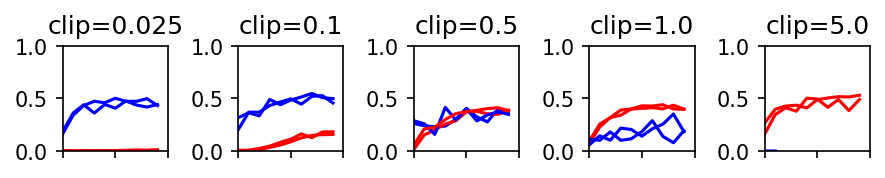

In [3]:
# We want to see what clip was best for the two different learning rates
lvl_0 = df.columns.get_level_values(level=0)
lvl_1 = df.columns.get_level_values(level=1)
# There must be a nicer way of doing this
cond_0 = lvl_0=="test_MAP_step"
cond_1 = lvl_1.isin(["clip", "learning_rate"])
rest_df = df.loc[:, cond_0 | cond_1]
# Now we plot the multiple learning curves for each clip
groups = rest_df.groupby(("params", "clip"))
ind = 1
print(rest_df)
for group_val, group in groups:
    ax = plt.subplot(1, len(groups) , ind)
    ind += 1
    print("------------------------")
    new_group = group.set_index([("params", "learning_rate"), ("params", "clip")]).transpose()
    subs = {0.002: "red", 0.2: "blue"}
    colours = [subs[lr] for lr in new_group.columns.get_level_values(0)]
    new_group.plot.line(ax=ax, legend=False, color=colours)
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.set_box_aspect(1)
    ax.set_title(f"clip={group_val}")
    ax.axis([0,10,0,1])

plt.tight_layout()
plt.show()

It appears that the network can still learn with very small clips as long as it can compensate with a larger learning rate. But this also shows that the graients > 0.1 contribute disproportionaty towards the learning process at normal learning rates. A clip of 5 still allows for the network to break in some way, but got the best scores for the normal learning rate. Perhaps a clip of 1.5 - 2 would be the best. Because this is not particularly important we can just settle for a clip of 1.5 and a learning rate << 0.2